# 1. Setup

In [56]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import ViTForImageClassification, ViTImageProcessor
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_recall_curve, roc_curve, accuracy_score,
    precision_score, recall_score, f1_score
)
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [57]:
test_dir = 'data/test'
model_path = 'best_model.pth'
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

label_map = {"Non-Fraud": 0, "Fraud": 1}
id2label = {0: "Non-Fraud", 1: "Fraud"}

In [58]:
# Dataset class

class FraudDataset(Dataset):
    def __init__(self, image_dir, processor, label_map, transform=None):
        self.image_paths = []
        self.labels = []
        self.processor = processor

        for label_name in os.listdir(image_dir):
            class_dir = os.path.join(image_dir, label_name)
            if os.path.isdir(class_dir):
                for fname in os.listdir(class_dir):
                    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(class_dir, fname))
                        self.labels.append(label_map[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        processed = self.processor(images=image, return_tensors="pt")
        item = {key: val.squeeze(0) for key, val in processed.items()}
        item["labels"] = label
        return item

# 2. Loading Model

In [59]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
test_dataset = FraudDataset(test_dir, processor, label_map)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

In [60]:
# Loading Model

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(label_map),
    id2label=id2label,
    label2id=label_map,
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

# 3. Running on Test Set

In [63]:
all_predictions = []
all_labels = []
all_probabilities = []
all_image_paths = []

test_progress = tqdm(test_loader, desc="Testing", unit="batch")

with torch.no_grad():
    for batch in test_progress:
        # Move inputs to device
        inputs = {k: v.to(device) for k, v in batch.items() 
                 if k not in ["labels"]}
        labels = batch["labels"]
        
        # Forward pass
        outputs = model(**inputs)
        
        # Get predictions and probabilities
        probabilities = torch.softmax(outputs.logits, dim=-1)
        predictions = torch.argmax(probabilities, dim=-1)
        
        # Store results
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probabilities.extend(probabilities.cpu().numpy())
        
        # Update progress bar
        current_acc = accuracy_score(all_labels, all_predictions)
        test_progress.set_postfix({'Accuracy': f'{current_acc:.3f}'})

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probabilities = np.array(all_probabilities)
fraud_probabilities = all_probabilities[:, 1]


Testing: 100%|██████████| 45/45 [01:09<00:00,  1.54s/batch, Accuracy=0.982]


In [64]:
# Basic metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='binary')
recall = recall_score(all_labels, all_predictions, average='binary')
f1 = f1_score(all_labels, all_predictions, average='binary')
auc = roc_auc_score(all_labels, fraud_probabilities)

# Print metrics
print(f"OVERALL PERFORMANCE:")
print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   AUC-ROC:   {auc:.4f}")

OVERALL PERFORMANCE:
   Accuracy:  0.9816 (98.16%)
   Precision: 0.9589
   Recall:    0.7527
   F1-Score:  0.8434
   AUC-ROC:   0.9693


# 4. Visualizations

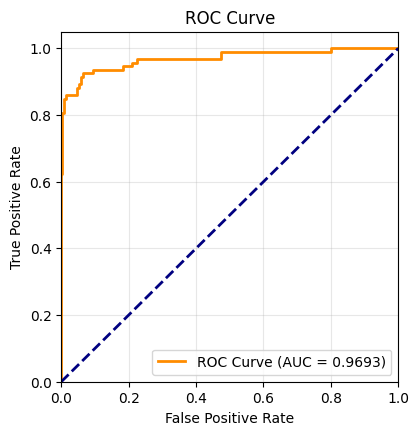

In [65]:
# ROC Curve

fig = plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 2)
fpr, tpr, _ = roc_curve(all_labels, fraud_probabilities)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

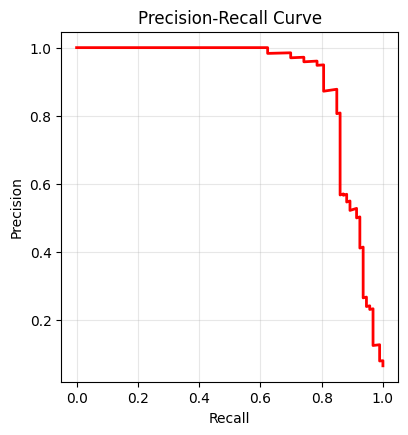

In [67]:
# Precision-Recall Curve

fig = plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 3)
precision_vals, recall_vals, _ = precision_recall_curve(all_labels, fraud_probabilities)
plt.plot(recall_vals, precision_vals, color='red', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(alpha=0.3)
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

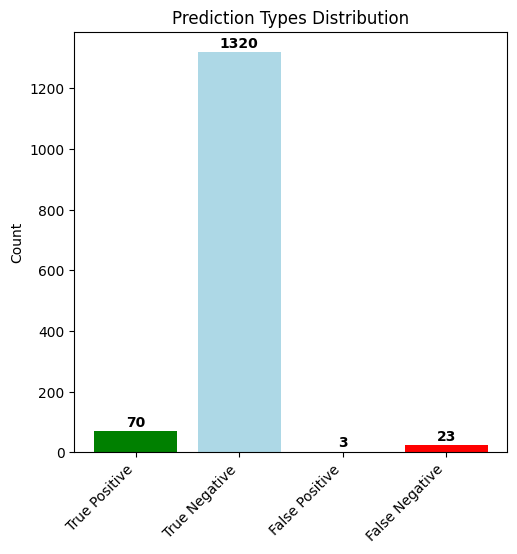

In [ ]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 8)

fp_mask = (all_labels == 0) & (all_predictions == 1)  # False Positives
fn_mask = (all_labels == 1) & (all_predictions == 0)  # False Negatives
tp_mask = (all_labels == 1) & (all_predictions == 1)  # True Positives  
tn_mask = (all_labels == 0) & (all_predictions == 0)  # True Negatives

error_counts = [np.sum(tp_mask), np.sum(tn_mask), np.sum(fp_mask), np.sum(fn_mask)]
error_labels = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
colors = ['green', 'lightblue', 'orange', 'red']

plt.bar(error_labels, error_counts, color=colors)
plt.title('Prediction Types Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for i, count in enumerate(error_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('test_results_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()